In [1]:
%load_ext autoreload
%autoreload 2
%cd '~/deepshape/deepshape'

/home/jorgen/deepshape/deepshape


In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

In [3]:
from layers import FourierLayer2D
from surfaces import *
from visual import get_plot_data
from networks import ReparametrizationNetwork2D

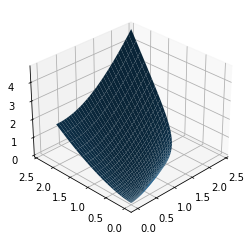

In [4]:
# TODO: Create example surfaces library, and load from there.
C = (
    lambda x: x[..., 0],
    lambda x: x[..., 1],
    lambda x: x[..., 0]**2 + x[..., 1]**2
)

f = Surface(C)
q = Qmap(f)
γ = Diffeomorphism((lambda x: x[..., 0], lambda x: 0.9*x[..., 1]**2 + 0.1 * x[..., 1]))

g = f.compose(γ)
r = Qmap(g)

Z = get_plot_data(r)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z)
ax.view_init(30, -135)
plt.show()

In [5]:
# Instantiate a 2-layer network with 5 basis functions per layer.
RN = ReparametrizationNetwork2D(3, 5)
optimizer = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.5)
# optimizer = optim.Adam(RN.parameters(), lr=1e-3)
RN.train(q, r, optimizer, iterations=500)

[Iter     1] loss: 0.07726
[Iter    11] loss: 0.04338
[Iter    21] loss: 0.03212
[Iter    31] loss: 0.02484
[Iter    41] loss: 0.01960
[Iter    51] loss: 0.01570
[Iter    61] loss: 0.01274
[Iter    71] loss: 0.01048
[Iter    81] loss: 0.00874
[Iter    91] loss: 0.00740
[Iter   101] loss: 0.00636
[Iter   111] loss: 0.00555
[Iter   121] loss: 0.00491
[Iter   131] loss: 0.00440
[Iter   141] loss: 0.00399
[Iter   151] loss: 0.00366
[Iter   161] loss: 0.00339
[Iter   171] loss: 0.00317
[Iter   181] loss: 0.00298
[Iter   191] loss: 0.00282
[Iter   201] loss: 0.00269
[Iter   211] loss: 0.00257
[Iter   221] loss: 0.00247
[Iter   231] loss: 0.00239
[Iter   241] loss: 0.00231
[Iter   251] loss: 0.00224
[Iter   261] loss: 0.00218
[Iter   271] loss: 0.00212
[Iter   281] loss: 0.00207
[Iter   291] loss: 0.00202
[Iter   301] loss: 0.00198
[Iter   311] loss: 0.00194
[Iter   321] loss: 0.00191
[Iter   331] loss: 0.00187
[Iter   341] loss: 0.00184
[Iter   351] loss: 0.00181
[Iter   361] loss: 0.00178
[

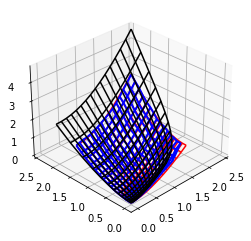

In [6]:
Zq = get_plot_data(q, k=16)
Zr = get_plot_data(r, k=16)
Zh = get_plot_data(lambda x: RN.reparametrized(r, x), k=16)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(*Zq, color='r')
ax.plot_wireframe(*Zh, color='b', lw=2.)
ax.plot_wireframe(*Zr, color='k')

ax.view_init(30, -135)